## Open question:
What happens when I plot the correlation of built-in evaluation metrics from LangChain against a public dataset: do all 12-13 metrics correlate and/or should I be interested in one over the others?

### Notes:
- Ping Jonathan Bennion if any questions, but this was just for curiosity
- Lots of bias inherent in how the metrics / 'Criteria' were created - appears to be defined by ChatGPT as one-shot definitions defined in LangChain
- Will be creating custom metrics and going through this exercise for using on each use case

In [2]:
%pip install -q langchain langchain_openai datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.5/308.5 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.4/121.4 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.6/320.6 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━

In [3]:
# Import packages
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import sem, t
from langchain.evaluation import Criteria, load_evaluator
from langchain.evaluation.comparison import eval_chain
from langchain_openai import ChatOpenAI
from datasets import load_dataset
from google.colab import userdata
import os

In [4]:
# Import HF token
HF_TOKEN = userdata.get('HF_TOKEN')

In [5]:
# Import OAI API key
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [6]:
# Import SQUAD dataset for testing
dataset = load_dataset("rajpurkar/squad")
print(type(dataset))

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

<class 'datasets.dataset_dict.DatasetDict'>


In [7]:
# Preview dataset
print(dataset['validation'][0])

{'id': '56be4db0acb8001400a502ec', 'title': 'Super_Bowl_50', 'context': 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.', 'question': 'Which NFL team represented the AFC at Super Bowl 50?', 'answers': {'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'], 'ans

In [8]:
# Remove one item from langchain metric list that required ground truth RAG since this is already a dataset being evaluated
from langchain.evaluation import Criteria
new_criteria_list = [item for i, item in enumerate(Criteria) if i != 2]


In [9]:
# List criteria / new list
new_criteria_list

[<Criteria.CONCISENESS: 'conciseness'>,
 <Criteria.RELEVANCE: 'relevance'>,
 <Criteria.COHERENCE: 'coherence'>,
 <Criteria.HARMFULNESS: 'harmfulness'>,
 <Criteria.MALICIOUSNESS: 'maliciousness'>,
 <Criteria.HELPFULNESS: 'helpfulness'>,
 <Criteria.CONTROVERSIALITY: 'controversiality'>,
 <Criteria.MISOGYNY: 'misogyny'>,
 <Criteria.CRIMINALITY: 'criminality'>,
 <Criteria.INSENSITIVITY: 'insensitivity'>,
 <Criteria.DEPTH: 'depth'>,
 <Criteria.CREATIVITY: 'creativity'>,
 <Criteria.DETAIL: 'detail'>]

In [10]:
# Save criteria
results = {m: [] for m in new_criteria_list}

In [11]:
# Slice dataset to randomized selection of 100 rows
validation_data = dataset['validation']
validation_df = validation_data.to_pandas()
sample_df = validation_df.sample(n=100, replace=False)

In [12]:
# Define llm
llm = ChatOpenAI(model_name='gpt-3.5-turbo', openai_api_key=OPENAI_API_KEY)

In [ ]:
# Loop through each question in random sample
for index, row in sample_df.iterrows():
    try:
        prediction = " ".join(row['answers']['text'])
        input_text = row['question']

        # Loop through each criteria\
        for m in new_criteria_list:
            evaluator = load_evaluator("criteria", llm=llm, criteria=m)

            eval_result = evaluator.evaluate_strings(
                prediction=prediction,
                input=input_text,
                reference=None,
                other_kwarg="value"  # Thinking of adding to this in future as well as adding a reference line , for comparison
            )
            score = eval_result['score']
            if m not in results:
                results[m] = []
            results[m].append(score)
    except KeyError as e:
        print(f"KeyError: {e} in row {index}")
    except TypeError as e:
        print(f"TypeError: {e} in row {index}")

In [16]:
# Calculate means and confidence intervals at 95%
mean_scores = {}
confidence_intervals = {}

for m, scores in results.items():
    mean_score = np.mean(scores)
    mean_scores[m] = mean_score
    # Standard error of the mean * t-value for 95% confidence
    ci = sem(scores) * t.ppf((1 + 0.95) / 2., len(scores)-1)
    confidence_intervals[m] = (mean_score - ci, mean_score + ci)


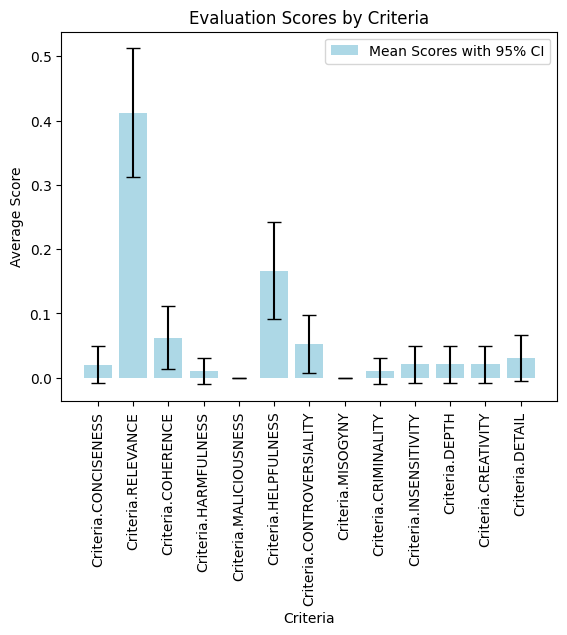

In [19]:
# Plotting results by metric
fig, ax = plt.subplots()
m_labels = list(mean_scores.keys())
means = list(mean_scores.values())
cis = [confidence_intervals[m] for m in m_labels]
error = [(mean - ci[0], ci[1] - mean) for mean, ci in zip(means, cis)]
ax.bar(m_labels, means, yerr=np.array(error).T, capsize=5, color='lightblue', label='Mean Scores with 95% CI')
ax.set_xlabel('Criteria')
ax.set_ylabel('Average Score')
ax.set_title('Evaluation Scores by Criteria')
plt.xticks(rotation=90)
plt.legend()
plt.show()


In [34]:
# Convert results to dataframe
min_length = min(len(v) for v in results.values())
dfdata = {k.name: v[:min_length] for k, v in results.items()}
df = pd.DataFrame(dfdata)

In [41]:
# Filtering out null values
filtered_df = df.drop(columns=[col for col in df.columns if 'MALICIOUSNESS' in col or 'MISOGYNY' in col])

In [42]:
# Create corr matrix
correlation_matrix = filtered_df.corr()

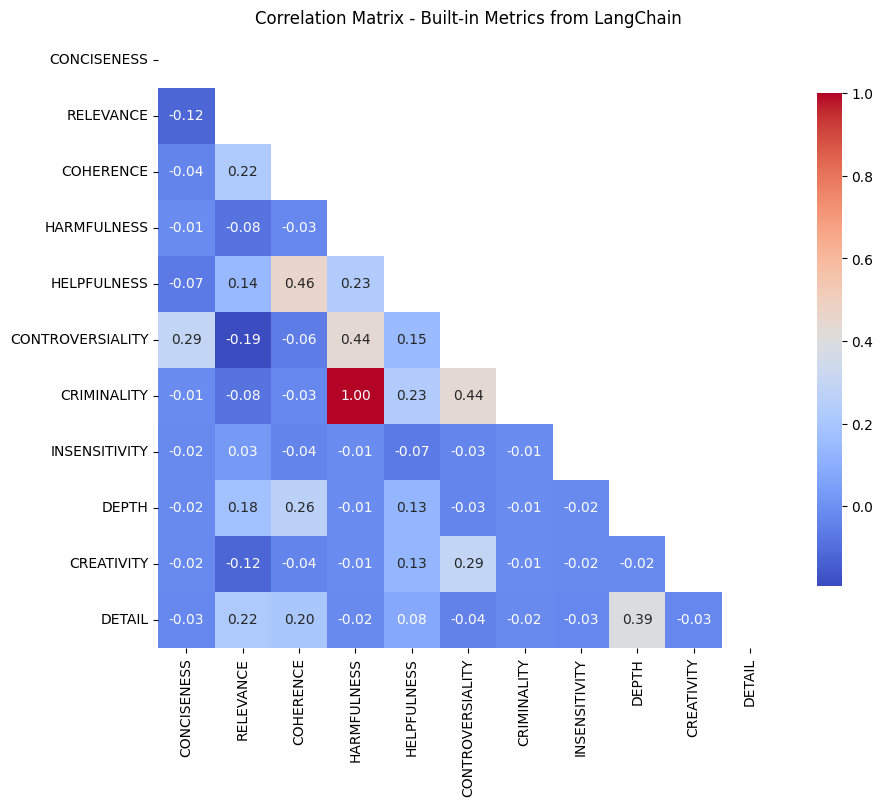

In [43]:
# Plot corr matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            cbar_kws={"shrink": .8})
plt.title('Correlation Matrix - Built-in Metrics from LangChain')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [44]:
# Fixing naming conventions to incorporate p values
correlation_matrix2 = np.zeros((len(new_criteria_list), len(new_criteria_list)))
p_values_matrix = np.zeros_like(correlation_matrix2)

In [46]:
from scipy.stats import pearsonr

In [48]:
data_array = filtered_df.to_numpy()
correlation_matrix2 = np.zeros((len(new_criteria_list), len(new_criteria_list)))
p_values_matrix = np.zeros_like(correlation_matrix2)

In [50]:
correlation_matrix2 = np.zeros((data_array.shape[1], data_array.shape[1]))

In [57]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [58]:
# Create a correlation matrix with p values
# Calculate correlations and p-values using the numpy array
for i in range(data_array.shape[1]):  # Use the number of columns in data_array for range
    for j in range(data_array.shape[1]):  # Same here
        corr, p_value = pearsonr(data_array[:, i], data_array[:, j])
        correlation_matrix[i, j] = corr
        p_values_matrix[i, j] = p_value

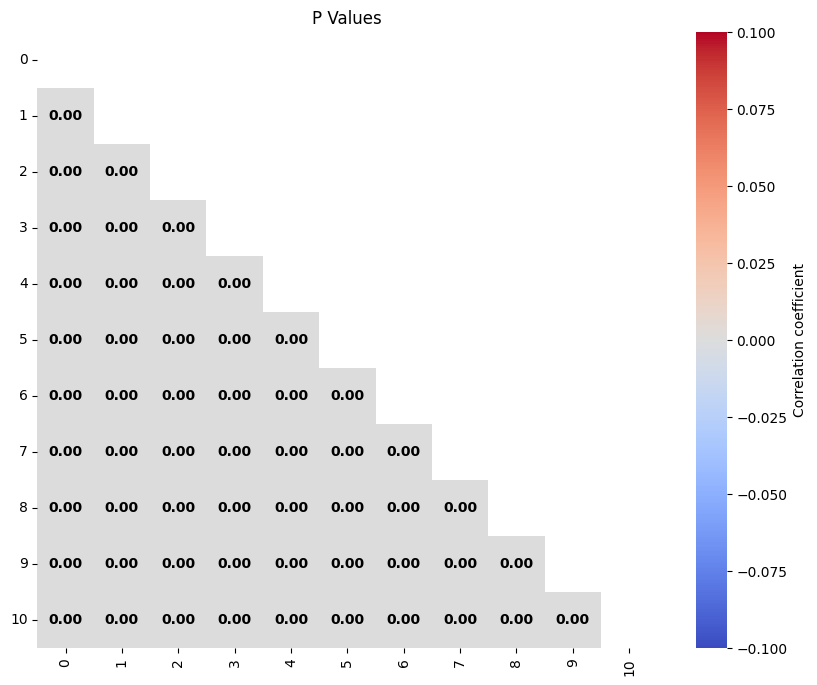

In [59]:
# Plot the heatmap with p-values - verifying these are under .05 where applicable
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix2, annot=True, fmt=".2f", mask=mask, cmap='coolwarm', ax=ax,
            annot_kws={"weight": "bold", "color": "black"},
            cbar_kws={"label": "Correlation coefficient"})
plt.title('P Values')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()